# QC, analysis of Gutenkunst three pop out of Africa
Here, we would like to do a sanity check that our models are producing similar results to that found 
in Gutenkunst 2009.  https://doi.org/10.1371/journal.pgen.1000695


In [1]:
import msprime
from stdpopsim import homo_sapiens
import allel
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from allel.util import asarray_ndim, check_integer_dtype
from matplotlib.colors import LogNorm
import math
import seaborn as sn

In [3]:
ch = "chr22"
chrom = homo_sapiens.genome.chromosomes[ch]
model = homo_sapiens.GutenkunstThreePopOutOfAfrica()

pops = ["YRI","CEU","CHB"]
treeSequencePath = "./HomoSapians3pop_"+ch+"_50samplesEach.trees"

The tree sequence for this simulation exists at the path 'treeSequencePath',
there is no need to re-simulate if it still exists.
The simulation only takes about a minute for a single chromosome.

In [6]:
# 50 samples each from YRI, CEU and CHB.
samples = [msprime.Sample(population=j, time=0) for j in range(3) for _ in range(100)]

ts = msprime.simulate(
    samples=samples,
    recombination_map=chrom.recombination_map(),
    mutation_rate=2*chrom.mean_mutation_rate,
    **model.asdict())
ts.dump(treeSequencePath)

First, lets take a look at comparisons to nucleotide diversity within all three populations.

In [7]:
ts = msprime.load(treeSequencePath)
gm = ts.genotype_matrix()

#make a haplotype data struct out of each population gentype matrices
haplotype_arrays = [allel.HaplotypeArray(gm[:,ts.samples(population=i)]) for i in range(3)]
total_haplo = allel.HaplotypeArray(gm)

#counts all ancestral/derived alleles at each site
allele_counts = [pop.count_alleles() for pop in haplotype_arrays]
total_ac = total_haplo.count_alleles()

#positions of all SNPs
pos = np.array([s.position for s in ts.sites()],dtype='float32')

for i,ac in enumerate(allele_counts):
    nd = allel.sequence_diversity(pos=pos,ac=ac)
    print("pop %s nucleotide diversity = " %(pops[i]),nd)
    
td = allel.sequence_diversity(pos=pos,ac=total_ac)
print("\ntotal nucleotide diversity: ",td)

pop YRI nucleotide diversity =  0.0006585150194946868
pop CEU nucleotide diversity =  0.0005649949823822066
pop CHB nucleotide diversity =  0.0004971295078766216

total nucleotide diversity:  0.0006276657782103799


Next, Lets look at the joint site frequency spectrum between all populations

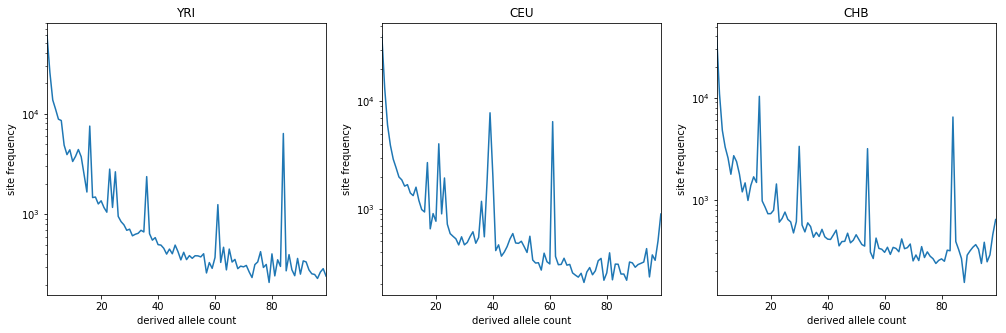

In [8]:
#Get derived counts from allele counts
dc = [ac[:,1] for ac in allele_counts]

fig0,ax0 = plt.subplots(1,3)
for i in range(3):
    fs = allel.sfs(dc[i])
    allel.plot_sfs(fs,ax=ax0[i])
    ax0[i].set_title(pops[i])
    
fig0.set_size_inches(17.0,5.0)
plt.show()

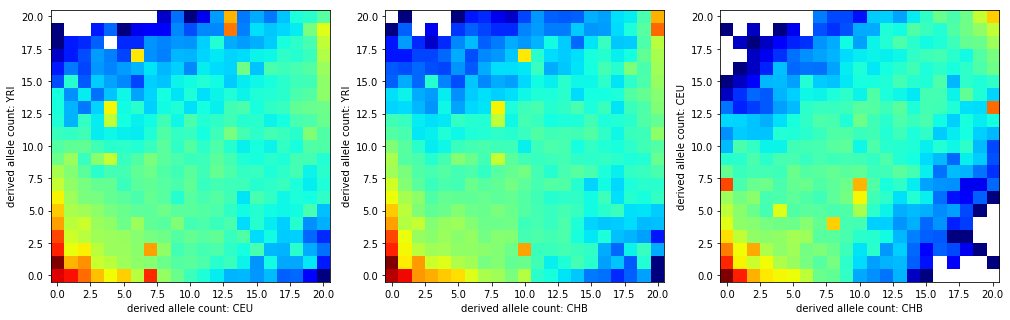

In [10]:
#compute joint site frequency spectrum between all combinations of populations

combs = [[1,0],[2,0],[2,1]]
joint_sfs = np.array([allel.joint_sfs(dc[comb[0]],dc[comb[1]]) for comb in combs])

fig1,ax1 = plt.subplots(1,3)
for i in range(3):
    #Z1 = bivariate_normal(X, Y, 0.1, 0.2, 1.0, 1.0) + 0.1 * bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
    data = joint_sfs[i]
    args = {"norm":LogNorm()}
    #norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
    #x = allel.plot_joint_sfs(data,ax=ax1[i],imshow_kwargs=args)
    x = allel.plot_joint_sfs(data,ax=ax1[i])
    #cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())),1+math.ceil(math.log10(data.max().max())))]
    ax1[i].set_xlabel("derived allele count: %s"%(pops[combs[i][0]]))
    ax1[i].set_ylabel("derived allele count: %s"%(pops[combs[i][1]]))


#plt.colorbar(mappable=data,cax=ax[2])
fig1.set_size_inches(17.0,5.0)
plt.show()

## Figure 2 from Gutenkunst 2009

![title](./journal.pgen.1000695.g002.png)

`Figure 2. Out of Africa analysis.

(A) AFS for the YRI, CEU, and CHB populations. The color scale is as in (C). (B) Illustration of the model we fit, with the 14 free parameters labeled. (C) Marginal spectra for each pair of populations. The top row is the data, and the second is the maximum-likelihood model. The third row shows the Anscombe residuals [61] between model and data. Red or blue residuals indicate that the model predicts too many or too few alleles in a given cell, respectively. (D) The observed decay of linkage disequilibrium (black lines) is qualitatively well-matched by our simulated data sets (colored lines). (E) Goodness-of-fit tests based on the likelihood and Pearson's statistic both indicate that our model is a reasonable, though incomplete description of the data. In both plots, the red line results from fitting the real data and the histogram from fits to simulated data. Poorer fits lie to the right (lower and higher ). (F) The improvement in likelihood from including contemporary migration in the real data fit (red line) is much greater than expected from fits to simulated data generated without contemporary migration (histogram). This indicates that the data contain a strong signal of contemporary migration.`

In [ ]:
# Next, we will replicate the Gutenkunst 2009 model step by step (Independent from the offical model put out by ) to compare to 